## Further analysis
We are going to do some more further statistical analysis on the data to see if we can find any patterns in the data to see whether there are certain types of individuals that are more likely to spend more time on social media to the detriment of their health or their studies. 
We need to import the following libraries to plot these visuals:

In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from scipy.stats import f_oneway
from scipy.stats import spearmanr
from scipy.stats import kruskal
import pingouin as pg

The first plot will be a correlation heatmap. This allows us to see whether there are any positive or negative correlation between the values within the dataset and will go a long way to answering whether our hypothesis are true or false.
Relationships range from 1.00 to -1.00.
The closer to 1.00 the relationship is means that there is positive correlation meaning as the first value goes up so does the second. Whereas the closer to -1.00 you get you'll be looking at negative correlation, as one value increases that will cause the second value to decrease. The closer to 0.00 means there is no causation and any pattern could be random.

Once the dataset is loaded in, we have assigned all object dtypes to a variable ready for conversion into numerical form for further analysis. We will iterate over each column in my_objects and assign them with a numerical value. For example gender values Male and Female will become 1 and 0 respectively. 

In [3]:
# Load the dataset
df = pd.read_csv('../data/cleaned_data/student_social_media_addiction_cleaned.csv')
df_plots = df.copy()

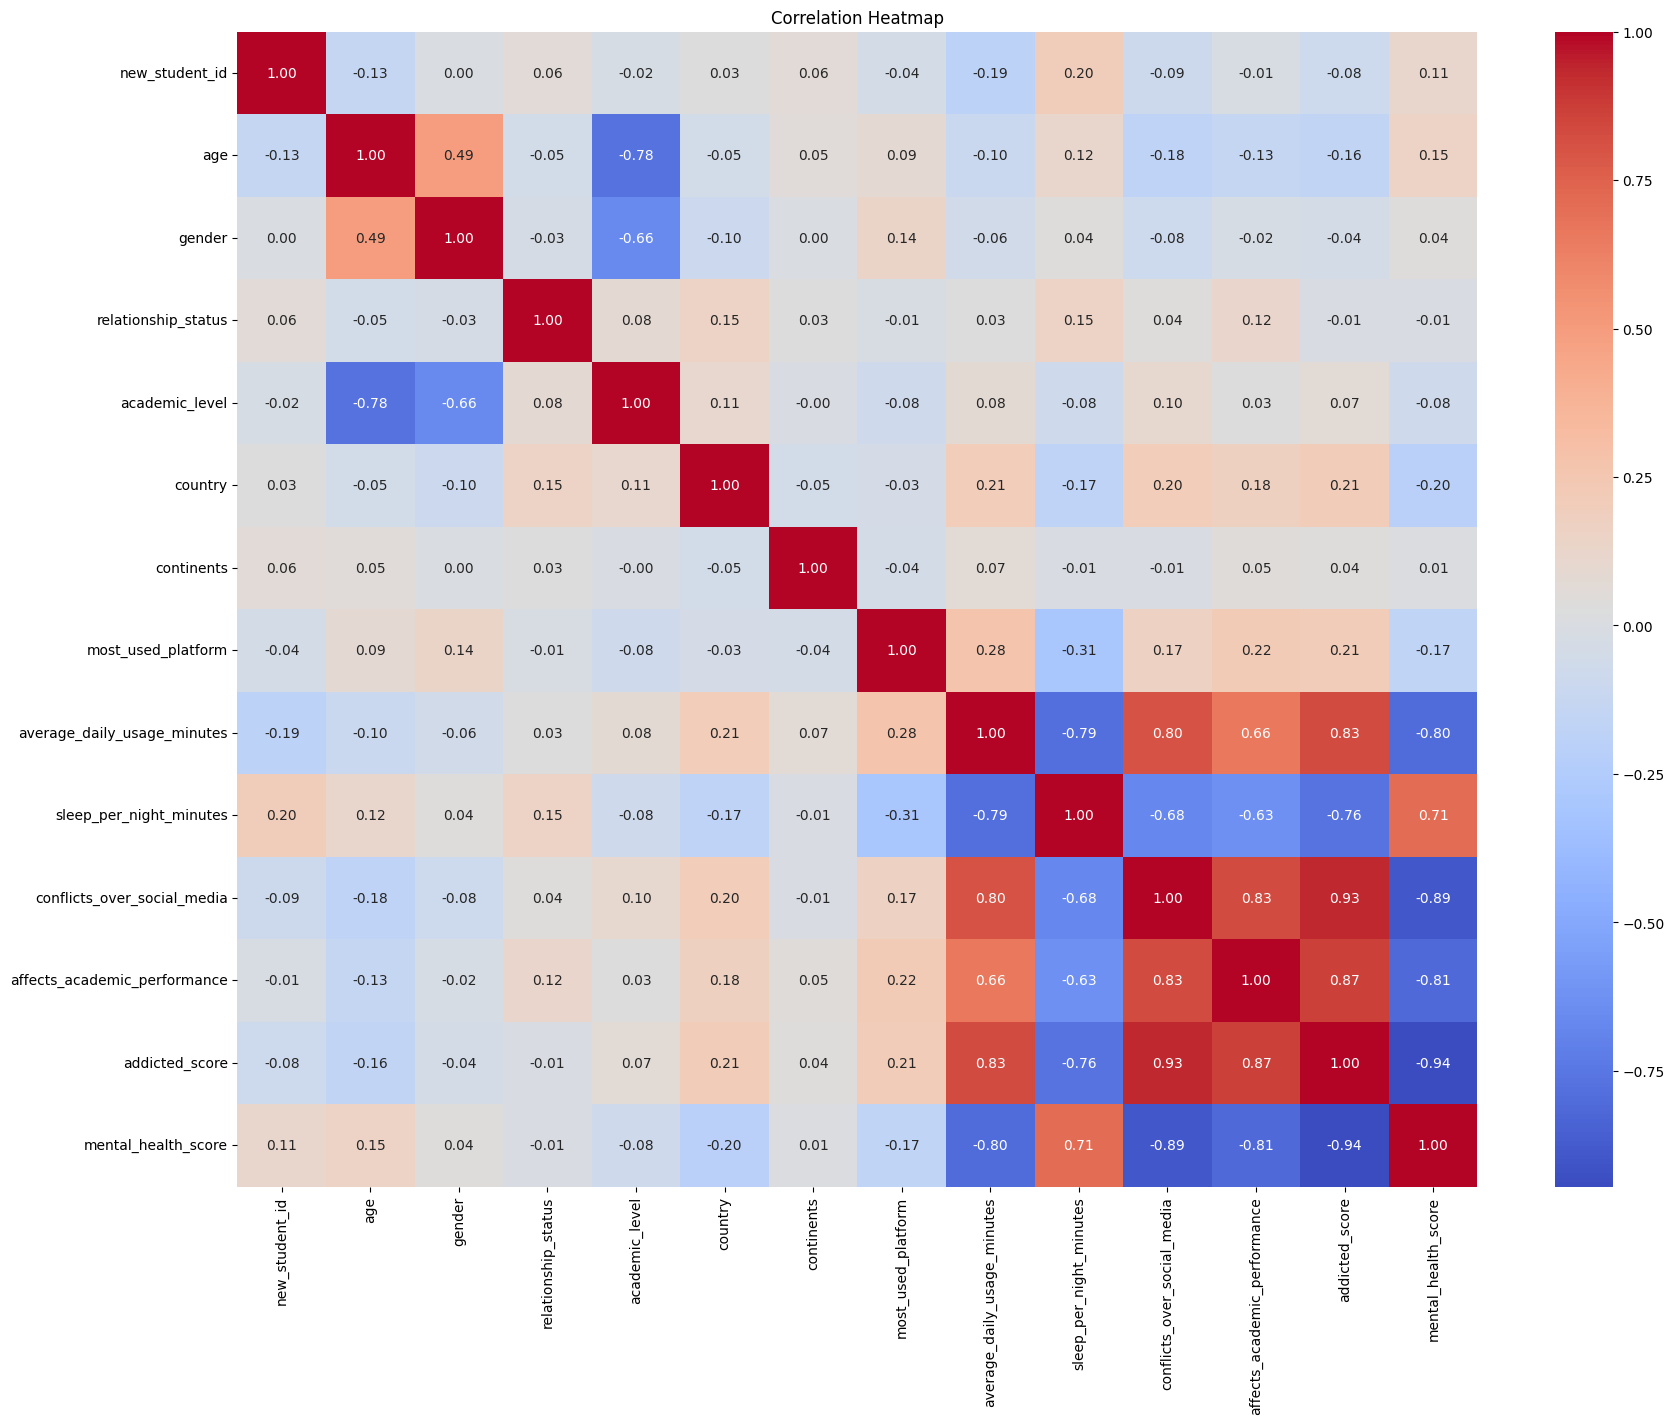

In [4]:
# Convert categoricals to number values, drop the categorical values already represented in minutes
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

cols_to_exclude = ['average_daily_use_by_hour', 'sleep_hours_per_night']

corr = df.drop(columns=cols_to_exclude).corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [5]:
# Document strong correlations ( > 0.75 or < -0.75 )
cols_to_exclude = ['average_daily_use_by_hour', 'sleep_hours_per_night']

df_corr = df.drop(columns=cols_to_exclude)

corr = df_corr.corr(numeric_only=True)

threshold = 0.75

strong_corrs = (
    corr.stack()
        .reset_index()
        .rename(columns={'level_0':'var1', 'level_1':'var2', 0:'corr'})
)

strong_corrs = strong_corrs[strong_corrs['var1'] != strong_corrs['var2']]

strong_corrs = strong_corrs[(strong_corrs['corr'] > threshold) | (strong_corrs['corr'] < -threshold)]

strong_corrs['pair'] = strong_corrs.apply(lambda x: tuple(sorted([x['var1'], x['var2']])), axis=1)
strong_corrs = strong_corrs.drop_duplicates(subset='pair').drop(columns='pair')
strong_corrs = strong_corrs.sort_values(by='corr', ascending=False)

strong_corrs


,var1,var2,corr
152,conflicts_over_social_media,addicted_score,0.932669
166,affects_academic_performance,addicted_score,0.867147
151,conflicts_over_social_media,affects_academic_performance,0.832498
124,average_daily_usage_minutes,addicted_score,0.829678
122,average_daily_usage_minutes,conflicts_over_social_media,0.803468
138,sleep_per_night_minutes,addicted_score,-0.764002
18,age,academic_level,-0.776261
121,average_daily_usage_minutes,sleep_per_night_minutes,-0.786871
125,average_daily_usage_minutes,mental_health_score,-0.800719
167,affects_academic_performance,mental_health_score,-0.808502


In [6]:
# Document medium correlations ( 0.5 > x <= 0.74 or -0.5 < x >= -0.74 )
cols_to_exclude = ['average_daily_use_by_hour', 'sleep_hours_per_night']  # example

df_corr = df.drop(columns=cols_to_exclude)

corr = df_corr.corr(numeric_only=True)

lower = 0.50
upper = 0.749

moderate_corrs = (
    corr.stack()
        .reset_index()
        .rename(columns={'level_0':'var1', 'level_1':'var2', 0:'corr'})
)
moderate_corrs = moderate_corrs[moderate_corrs['var1'] != moderate_corrs['var2']]

moderate_corrs = moderate_corrs[
    ((moderate_corrs['corr'] >= lower) & (moderate_corrs['corr'] <= upper)) |
    ((moderate_corrs['corr'] <= -lower) & (moderate_corrs['corr'] >= -upper))
]

moderate_corrs['pair'] = moderate_corrs.apply(lambda x: tuple(sorted([x['var1'], x['var2']])), axis=1)
moderate_corrs = moderate_corrs.drop_duplicates(subset='pair').drop(columns='pair')

moderate_corrs = moderate_corrs.sort_values(by='corr', ascending=False)

moderate_corrs


,var1,var2,corr
139,sleep_per_night_minutes,mental_health_score,0.707560
123,average_daily_usage_minutes,affects_academic_performance,0.662701
137,sleep_per_night_minutes,affects_academic_performance,-0.625949
32,gender,academic_level,-0.658585
136,sleep_per_night_minutes,conflicts_over_social_media,-0.676934


To evaluate each of my hypotheses, I will plot the relevant variables and analyse their relationships using appropriate statistical tests. Since normality testing showed that none of the variables are normally distributed, I will use non-parametric methods to measure the strength and direction of the relationships. The main test used will be spearmans rank. 
This analysis will allow me to determine whether meaningful associations exist between the variables and whether the hypotheses are proved or disproved by the data.

## Hypothesis one:  
## _'Higher average daily use will have a negative impact on sleep per night'_

H₀ - Null hypothesis:
There is no relationship between average daily social media use and sleep per night.

H₁ - Alternative Hypothesis
Higher average daily social media use has a negative impact on sleep per night.

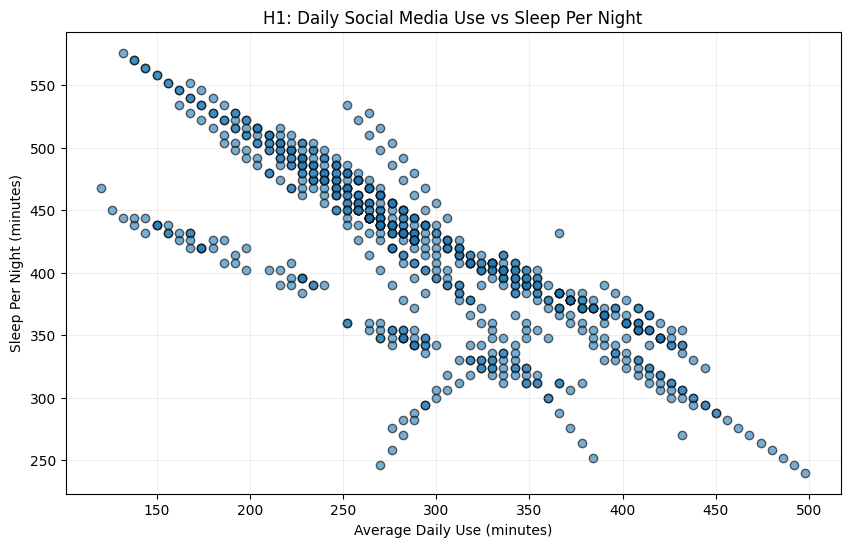

In [7]:
# Plot daily social media use v amount of sleep on a scatterplot
plt.figure(figsize=(10, 6))

plt.scatter(
    df_plots["average_daily_usage_minutes"],
    df_plots["sleep_per_night_minutes"],
    alpha=0.6,
    edgecolor="black"
)

plt.title("H1: Daily Social Media Use vs Sleep Per Night")
plt.xlabel("Average Daily Use (minutes)")
plt.ylabel("Sleep Per Night (minutes)")
plt.grid(True, alpha=0.2)

plt.show()

The scatter plot shows a clear negative relationship between average daily social media use and the amount of sleep users were getting per night. As daily use increases, sleep time tends to decrease, forming a downward trend across the data. Whilst there is some variance in sleep due to some people not needing as much sleep as others, the overall pattern suggests that increased use of social media does impact sleep.

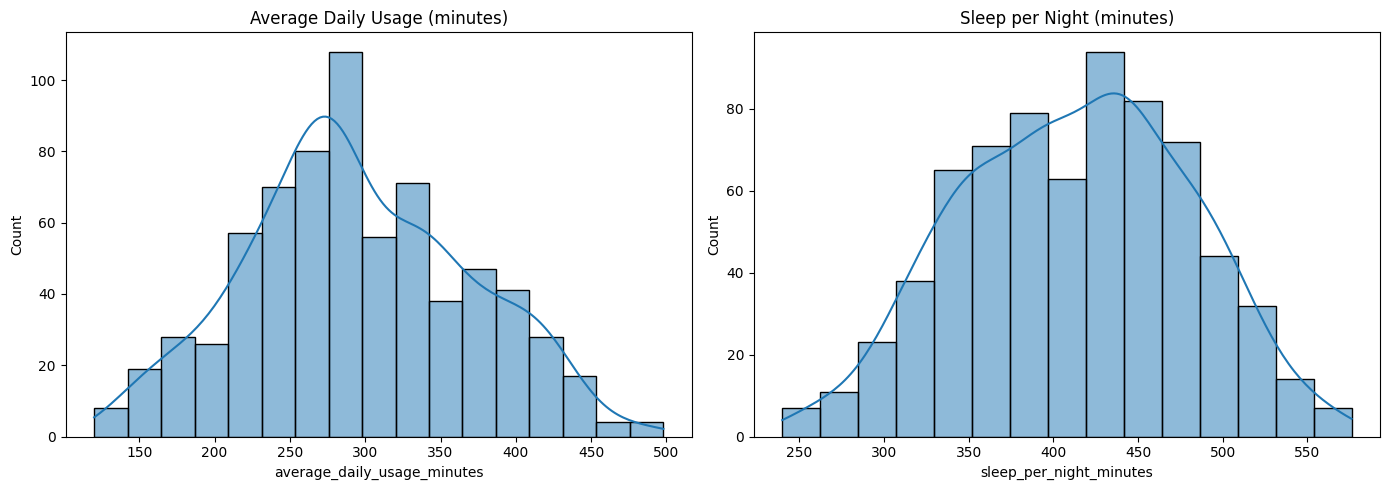

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_plots['average_daily_usage_minutes'], kde=True, ax=axes[0])
axes[0].set_title('Average Daily Usage (minutes)')


sns.histplot(df_plots['sleep_per_night_minutes'], kde=True, ax=axes[1])
axes[1].set_title('Sleep per Night (minutes)')

plt.tight_layout()
plt.show()

Looking at the histogram plots the data does look to be normally distributed, however the normality test in Pingouins library proved the the data wasn't normally distributed, immediately ruling out some of the statistical tests that I could use on the data.

In [9]:
# Check pval and distribution of the fields
pg.normality(data=df_plots, alpha=0.05)

,W,pval,normal
age,0.926535,4.975550e-18,False
average_daily_usage_minutes,0.990333,1.439745e-04,False
average_daily_use_by_hour,0.937702,1.513712e-16,False
sleep_per_night_minutes,0.992407,1.196030e-03,False
sleep_hours_per_night,0.992407,1.196030e-03,False
conflicts_over_social_media,0.901126,7.068930e-21,False
addicted_score,0.922405,1.546806e-18,False
mental_health_score,0.907530,3.242839e-20,False


In [10]:
# Calculate correlation and pvalue using Spearman's rank
rho, pval = spearmanr(df_plots['average_daily_usage_minutes'], df_plots['sleep_per_night_minutes'])
print(rho, pval)

-0.8125293751694888 3.129516654289552e-166


### Hypothesis 1 result:

I chose to test my first hypothesis by using Spearman’s rank to examine whether increased daily usage of social media was associated with lower sleep scores. The results backed up what is shown on the scatter plot that there is a very strong negative correlation between the two variables, indicating that more screen time a person gets is heavily linked to them getting less sleep per night. 
Therefore, a correlation score of (-0.81) and a pval < 0.05 (3.13 × 10⁻¹⁶⁶) show that we can *reject the null hypothesis*. 

## Hypothesis two:  
## _'More conflicts over social media (with friends, family or partners) will lead to a lower mental health score'_

H₀ - Null hypothesis:
There is no relationship between conflicts on social media and mental health score

H₁ - Alternative Hypothesis
Having a higher number of conflicts over social media will be associated to lower mental health scores

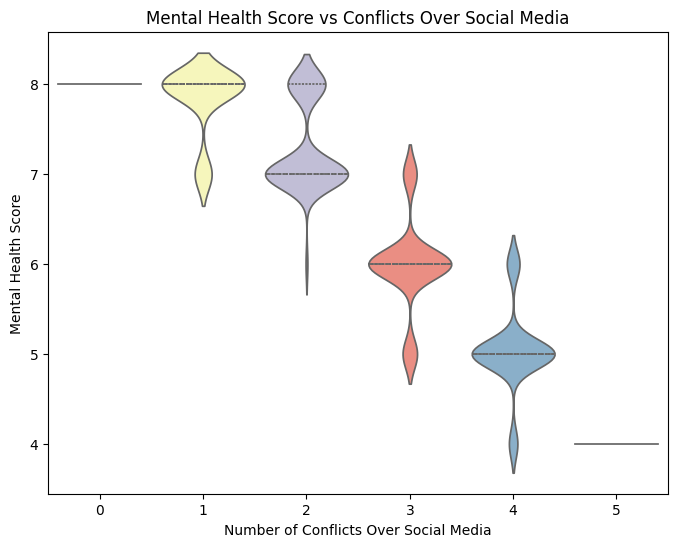

In [11]:
plt.figure(figsize=(8,6))
sns.violinplot(data=df_plots, x='conflicts_over_social_media', y='mental_health_score', inner='quartile', palette='Set3', hue='conflicts_over_social_media', legend=False)

plt.title("Mental Health Score vs Conflicts Over Social Media")
plt.xlabel("Number of Conflicts Over Social Media")
plt.ylabel("Mental Health Score")
plt.show()

The violin plot shows the distribution of mental health scores for individuals across a varying numbers of social media conflicts. We can observe that as the number of conflicts increases, the mental health score tends to decrease and the spread of scores shifts slightly downward. By using a violin plot we are able to identify that not only does the range move, the median does too. This pattern supports the hypothesis that more conflicts over social media may negatively affect mental health.

In [12]:
# Calculate correlation and pvalue using Spearman's rank
rho, pval = spearmanr(df_plots['conflicts_over_social_media'], df_plots['mental_health_score'])
print(rho, pval)

-0.9076157763758137 4.490071679264819e-266


### Hypothesis 2 result:

I chose to test my second hypothesis by using Spearman’s rank to examine whether increased conflicts over social media are associated with lower mental-health scores. The results backed up what is shown on the violin plot that there is a very strong negative correlation between the two variables, indicating that higher levels of conflict are consistently linked to significantly lower mental-health scores. 
Therefore, with a correlation score of (-0.90) and a pval < 0.05 (4.49 × 10⁻²⁶⁶) we can *reject the null hypothesis*

## Hypothesis Three:  
## _'TikTok users will have the lowest mental health scores'_

H₀ - Null hypothesis:
There is no distinction to be made between the mental health score of TikTok users in comparison to other social media platforms

H₁ - Alternative Hypothesis
TikTok users have a lower mental health score than users who used alternative platforms as their main source of social media

In [13]:
# Check value counts for each platform
df_plots['most_used_platform'].value_counts()

most_used_platform
Instagram    248
TikTok       153
Facebook     123
WhatsApp      54
Twitter       30
LinkedIn      20
WeChat        15
Snapchat      13
LINE          12
KakaoTalk     12
VKontakte     12
YouTube       10
Name: count, dtype: int64

In [14]:
top_platforms = df_plots['most_used_platform'].value_counts().head(3).index

df_top = df_plots[df_plots['most_used_platform'].isin(top_platforms)]

platform_counts = df_top.groupby(['most_used_platform', 'affects_academic_performance']).size().reset_index(name='count')

platform_pivot = platform_counts.pivot(index='most_used_platform', columns='affects_academic_performance', values='count').fillna(0)

avg_mh = df_top.groupby('most_used_platform')['mental_health_score'].mean().reindex(platform_pivot.index).reset_index()

fig = go.Figure()

for col in platform_pivot.columns:
    fig.add_trace(go.Bar(
        x=platform_pivot.index,
        y=platform_pivot[col],
        name=f"Affects Academic Performance: {col}"
    ))

fig.add_trace(go.Scatter(
    x=platform_pivot.index,
    y=avg_mh['mental_health_score'],
    name='Average Mental Health Score',
    mode='lines+markers',
    marker_color='red',
    yaxis='y2'
))

fig.update_layout(
    title='Top 3 Platforms vs Average Mental Health (Split by Academic Impact)',
    xaxis=dict(title='Platform'),
    yaxis=dict(title='Number of Users', side='left'),
    yaxis2=dict(title='Average Mental Health Score', overlaying='y', side='right'),
    barmode='group',
    legend=dict(x=0.1, y=1.1, orientation='h')
)

fig.show()


For this hypothesis I used Plotly to display user counts per platform alongside scatter overlays showing average mental health scores. I focused my analysis on the top three platforms (TikTok, Instagram, Facebook) as the others didn't have enough data and were reporting erratic average mental health scores. As there was now only three platforms I dived further into the user feedback for each platform and included whether users had reported that it had affected their academic performance or not.

TikTok users showed the lowest mental health scores and the highest rate of reported academic impact at 93.46%, compared to 68.95% for Instagram and 30.08% for Facebook, where remarkabley more users reported no academic effects than those who did.

In [15]:
social_platforms = [df_plots[df_plots['most_used_platform']=='TikTok']['mental_health_score'],
          df_plots[df_plots['most_used_platform']=='Instagram']['mental_health_score'],
          df_plots[df_plots['most_used_platform']=='Facebook']['mental_health_score'],
]
kruskal(*social_platforms)

KruskalResult(statistic=58.903214131632694, pvalue=1.6193083977260818e-13)

### Hypothesis 3 result:

I chose to test my third hypothesis using a Kruskal Wallis test to check whether there was a difference in mental health scores across different social media platforms. This statistical analysis indicates that users of at least one platform differ in mental health scores from the others, without explicity telling us which one. This does however support the findings on the plotly plot that of the 3 largest by count in the dataset TikTok users have a worse mental health score than users of other platforms.

Therefore, with a Kruskal-Wallis score of (H = 58.90, p < 0.001) we can *reject the null hypothesis* that TikTok users do not differ from other platform users.

## Hypothesis Four:  
## _'Addiction level have an impact on sleep duration'_

H₀ - Null hypothesis:
Addiction level has little to no impact on sleep

H₁ - Alternative Hypothesis
Sleep duration will be affected by addiction level.

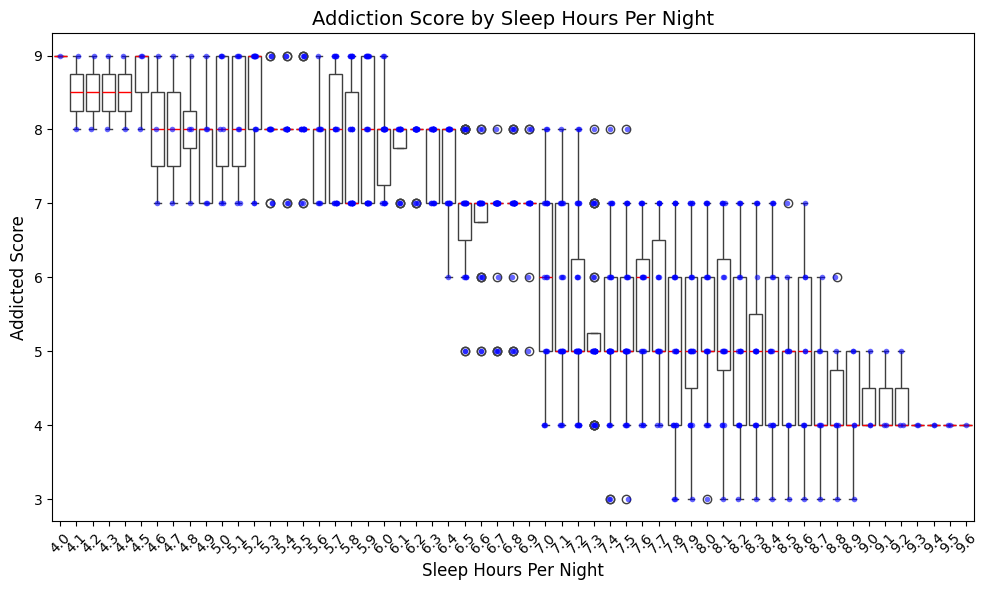

In [16]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df_plots,
    x='sleep_hours_per_night',
    y='addicted_score',
    showcaps=True,
    boxprops={'facecolor': 'None'},
    medianprops={'color': 'red'},
)

sns.stripplot(
    data=df_plots,
    x='sleep_hours_per_night',
    y='addicted_score',
    color='blue',
    size=4,
    alpha=0.6
)

plt.title("Addiction Score by Sleep Hours Per Night", fontsize=14)
plt.xlabel("Sleep Hours Per Night", fontsize=12)
plt.ylabel("Addicted Score", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


For this hypothesis I combined two plots, a boxplot and strip plot. By using the strip plot I was able to plot the amount of sleep each user was getting against their addiction score level. Due to it being a busy plot with all these points I decided to inclcude the boxplot to illustrate how the range changes amongst these points. As you amount of sleep decreases, the median addiction level gets higher and the range also gets smaller. When users are getting more sleep the 25-75 percentiles addiction scores range across 3 or 4 levels whereas as you get higher they are much more concentrated, those getting less than 5 hours sleep per night are typically across 2 addiction levels.

In [17]:
rho, pval = spearmanr(df_plots['addicted_score'], df_plots['sleep_per_night_minutes'])
print(rho, pval)

-0.7859987278680912 2.440940960646953e-148


### Hypothesis 4 result:

I chose to test my fourth hypothesis by using Spearman’s rank to examine whether the users' addiction level was associated with lower sleep scores. The results supported the findings in the strip plot and boxplot above that there is a very strong negative correlation between the two variables, people getting less sleep can be heavily attributed to the fact that they're addicted to social media.

Therefore, a correlation score of (-0.79) and a pval < 0.05 (2.44 × 10⁻¹⁴⁸) show that we can *reject the null hypothesis*. 

# Summary of findings v hypothesis

| Hypothesis | Statistical Test | Statistic / Correlation | p-value | Interpretation / Result |
|------------|----------------|------------------------|---------|------------------------|
| H1: Higher daily social media use → less sleep | Spearman's rank correlation | ρ = -0.813 | 3.13 × 10⁻¹⁶⁶ | Strong negative correlation, reject H₀ |
| H2: More conflicts → lower mental health | Spearman's rank correlation | ρ = -0.908 | 4.49 × 10⁻²⁶⁶ | Strong negative correlation, reject H₀ |
| H3: TikTok users have lowest mental health | Kruskal–Wallis H-test | H = 58.90 | 1.62 × 10⁻¹³ | Significant difference between platforms, reject H₀ |
| H4: Higher addiction → less sleep | Spearman's rank correlation | ρ = -0.786 | 2.44 × 10⁻¹⁴⁸ | Strong negative correlation, reject H₀ |
